In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This function seeks all turns which are smaller than the max_unacceptable_length and sets them to 0
# Hence deleting turns that are shorter than max_unacceptable_length
def short_turns_to_0(samp, max_unacceptable_length):
    edited_samp = np.zeros(len(samp))
    prev = 0
    
    i = 0
    while i < len(samp):
        s = samp[i]
        edited_samp[i] = s
        # If there is a step up in the VAD
        if prev == 0 and s == 1:
            # Check if any in the coming p are 0 (then we have a short turn of p)
            for j, s2 in enumerate(samp[i+1:i+1+max_unacceptable_length]):
                if s2 == 0:
                    # Found a 0 within the allowed time, overwrite all corresponding 1s to 0s
                    for k in range(i,i+1+j):
                        edited_samp[k] = 0.
                    i = i + j
                    break
        i = i + 1
        prev = s 
    
    return edited_samp

In [3]:
# This function seeks all turn pauses which are smaller than the max_pause_length and sets these pauses to 1
# Hence merging turns that are less than max_pause_length apart
def pauses_to_1(samp, max_pause_length):
    edited_samp = np.zeros(len(samp))
    prev = 0
    
    i = 0
    while i < len(samp):
        s = samp[i]
        edited_samp[i] = s
        # If there is a step down in the VAD
        if prev == 1 and s == 0:
            # Check if any in the coming p are 1 (then we have a pause of p)
            for j, s2 in enumerate(samp[i+1:i+1+max_pause_length]):
                if s2 == 1:
                    # Found a 1 within the allowed time, overwrite all corresponding 0s to 1s
                    for k in range(i,i+1+j):
                        edited_samp[k] = 1.
                    i = i + j
                    break
        i = i + 1
        prev = s 
    
    return edited_samp

In [4]:
# This function counts the number of turns in a VAD array
def count_turns(samp):
    prev = 0
    total = 0
    
    for i, s in enumerate(samp):
        # If there is a step up in the VAD
        if prev == 0 and s == 1:
            total += 1
        prev = s 
    
    return total

In [5]:
# Visualize a binary array
def viz(data):
    xaxis = np.arange(0, len(data))
    yaxis = np.array(data)
    plt.step(xaxis, yaxis)
    plt.show()

# Processing the LaRed VADs

In [6]:
participants = [2, 3, 4, 5, 7, 10, 11, 12, 14, 15, 17, 18, 19, 22, 23, 24, 26, 27, 30, 31, 32, 33, 34, 35]

In [7]:
# Keep in mind that it is samples in 100 Hz
# So a parameter of 100 means 1 second
max_unacceptable_turn_length = 150
max_pause_length = 150

# The above parameters are optimized empirically by trying values and looking at the resulting VAD
# and at the same time listening to the corresponding audio in audacity (for some random data segments).
# The VADs processed with these values capture turns quite well.

# Process the VAD files by merging turns with a short pause and by removing short turns (likely backchannels)
for participant in participants:
    samplerate, data = wavfile.read(f'vad/{participant}.wav')
    processed = pauses_to_1(data, max_pause_length)
    processed = short_turns_to_0(processed, max_unacceptable_turn_length)
    
    print(f"Participant {participant} had {count_turns(data)} turns. {count_turns(processed)} turns left.")
    
    wavfile.write(f'vad_processed/{participant}.wav', samplerate, processed)

Participant 2 had 1475 turns. 307 turns left.
Participant 3 had 1257 turns. 259 turns left.
Participant 4 had 955 turns. 221 turns left.
Participant 5 had 1090 turns. 192 turns left.
Participant 7 had 1792 turns. 361 turns left.
Participant 10 had 823 turns. 222 turns left.
Participant 11 had 836 turns. 199 turns left.
Participant 12 had 758 turns. 200 turns left.
Participant 14 had 823 turns. 180 turns left.
Participant 15 had 925 turns. 201 turns left.
Participant 17 had 992 turns. 206 turns left.
Participant 18 had 1305 turns. 142 turns left.
Participant 19 had 442 turns. 88 turns left.
Participant 22 had 614 turns. 215 turns left.
Participant 23 had 1280 turns. 286 turns left.
Participant 24 had 1096 turns. 253 turns left.
Participant 26 had 997 turns. 220 turns left.
Participant 27 had 429 turns. 118 turns left.
Participant 30 had 856 turns. 176 turns left.
Participant 31 had 409 turns. 66 turns left.
Participant 32 had 936 turns. 118 turns left.
Participant 33 had 629 turns. 150 

# (Appendix) Illustration of difference with order of operations

The output can differ depending on whether you apply short_turns_to_0 or pauses_to_1 first. The difference is visualized here. Empirically we found that the second version works best for capturing natural turn-taking behaviour from VAD.

Original array:
[0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.] (4 turns)
Processed (short turns to 0 first):
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (1 turns)
------------------------------------------------------------
Original array:
[0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.] (4 turns)
Processed (pauses to 1 first):
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] (1 turns)


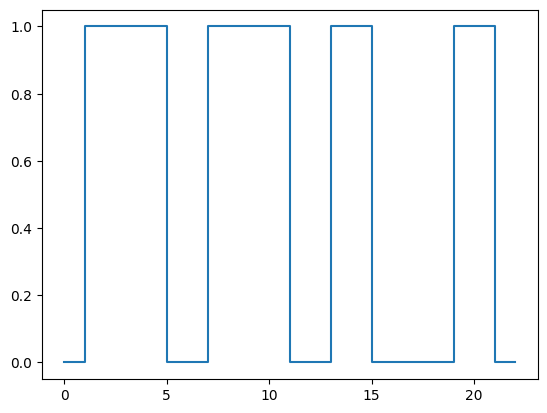

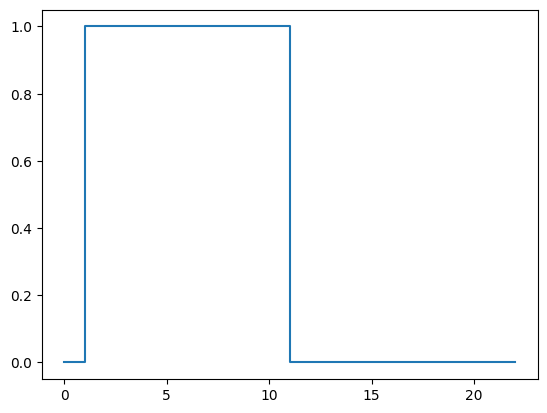

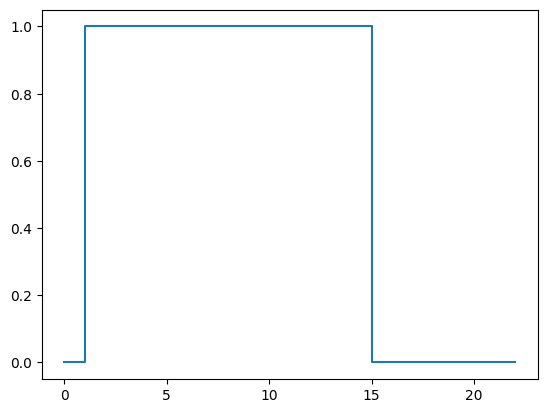

In [8]:
check = np.array([0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0, 0, 1., 1., 0., 0., 0., 0., 1., 1., 0.])
print(f"Original array:\n{check} ({count_turns(check)} turns)")
ed1 = short_turns_to_0(check, 2)
ed1 = pauses_to_1(ed1, 2)
print(f"Processed (short turns to 0 first):\n{ed1} ({count_turns(ed1)} turns)")
print('-'*60)

print(f"Original array:\n{check} ({count_turns(check)} turns)")
ed2 = pauses_to_1(check, 2)
ed2 = short_turns_to_0(ed2, 2)
print(f"Processed (pauses to 1 first):\n{ed2} ({count_turns(ed2)} turns)")

viz(check)
viz(ed1)
viz(ed2)